 This is code to generate a deep learning model with the goal of detecting finfan failures at an earlier point in time than currently.
 This is done using the keras library and making and sequential model.
 I have used binary classification to use as the output of the model.
 Using a window of a specified size, it attempts to predict if a finfan is going to fail within that window.
 Author: Andrew Gansemer

 Import the required libraries and some set up

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from datafunctions import convert_data, calc_rul, normalise, gen_sequence, gen_labels

# to make results reproducible, remove or set to secret in production
np.random.seed(1010)
PYTHONHASHSEED = 0

model_path = "./finfanOUT/bin_model.h5"


In [2]:
# Constant definitions
# the size of the blocks of data to be fed to the model, the larger the better
sequence_length = 50
# the number of days to predict failure within
w1 = pd.Timedelta(days=-30)
# scaler selection
minmax_scaler = preprocessing.MinMaxScaler()
# below should be all input variables given to the model
# list of all sensors used
sensor_cols = ["speed"]
# list of other variables
sequence_cols = ["status"]
sequence_cols.extend(sensor_cols)
# Data input: Read in the data and add to a list, for further processing
train_df1 = pd.read_csv(
    "./finfanIN/Data_Extract_Train.txt", sep="\t", header=None, low_memory=False
)
train_df2 = pd.read_csv(
    "./finfanIn/Data_Extract_Train2.txt", sep="\t", header=None, low_memory=False
)
train_dfs = [train_df1, train_df2]


In [3]:
# converts the list of training dataframes to the correct format and adds it a single dataframe with an id column
# it cleans the data and merges all the time columns, calculates time until failure (assumed last point in the input data)
# and normalises the data using the scaler chosen, by default uses minmax which scales it to between 0 and 1
train = None
for i, t in enumerate(train_dfs):
    if train is None:
        train = normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)
    else:
        train = pd.concat(
            [train, normalise(calc_rul(convert_data(t, i), w1), minmax_scaler)],
            copy=False,
        )
print(train)


                      time   speed  status  id
0      2019-01-01 00:00:09  2644.0     0.0   0
1      2019-01-01 00:00:19  2645.0     0.0   0
2      2019-01-01 00:01:09  2645.0     0.0   0
3      2019-01-01 00:01:19  2644.0     0.0   0
4      2019-01-01 00:01:29  2645.0     0.0   0
...                    ...     ...     ...  ..
366009 2019-08-13 13:50:11    -5.0     0.0   0
366010 2019-08-13 21:47:17    -5.0     0.0   0
366011 2019-08-14 05:47:11    -5.0     0.0   0
366012 2019-08-14 13:42:10    -5.0     0.0   0
366013 2019-08-14 18:42:50    -5.0     1.0   0

[366014 rows x 4 columns]
                       time     speed  status  id                RUL  label1  \
0       1546300809000000000  0.996615     0.0   0 -19507361000000000       0   
1       1546300819000000000  0.996991     0.0   0 -19507351000000000       0   
2       1546300869000000000  0.996991     0.0   0 -19507301000000000       0   
3       1546300879000000000  0.996615     0.0   0 -19507291000000000       0   
4       1

 Start of LSTM model section

In [4]:
# generates the data chunks to be input into the model from the data previously formatted above
seq_gen = (
    list(gen_sequence(train[train["id"] == id], sequence_length, sequence_cols))
    for id in train["id"].unique()
)
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)


(655534, 50, 2)


In [5]:
# generates the labels signifying if the failure will happen within the next 30 days
label_gen = [
    gen_labels(train[train["id"] == id], sequence_length, ["label1"])
    for id in train["id"].unique()
]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(655534, 1)

 Define the layers and shape of the internals of the model

In [6]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(
    LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True)
)
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           41200     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# generate a model to try to correctly predict outputs based on the given data
# save the model which best predicts
history = model.fit(
    seq_array,
    label_array,
    epochs=10,
    batch_size=200,
    validation_split=0.2,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="min"
        ),
        keras.callbacks.ModelCheckpoint(
            model_path, monitor="val_loss", save_best_only=True, mode="min", verbose=0
        ),
    ],
)
print(history.history.keys())


Epoch 1/10
2623/2623 - 52s - loss: 0.4402 - accuracy: 0.7969 - val_loss: 0.6319 - val_accuracy: 0.9933
Epoch 2/10
2623/2623 - 53s - loss: 0.4433 - accuracy: 0.7971 - val_loss: 0.6832 - val_accuracy: 0.9939
Epoch 3/10
2623/2623 - 54s - loss: 0.4328 - accuracy: 0.8010 - val_loss: 0.6533 - val_accuracy: 0.9940
Epoch 4/10
2623/2623 - 60s - loss: 0.4338 - accuracy: 0.8007 - val_loss: 0.7293 - val_accuracy: 0.0020
Epoch 5/10
2623/2623 - 59s - loss: 0.4308 - accuracy: 0.8016 - val_loss: 0.5830 - val_accuracy: 0.9987
Epoch 6/10
2623/2623 - 55s - loss: 0.4302 - accuracy: 0.8026 - val_loss: 0.6110 - val_accuracy: 0.9987
Epoch 7/10
2623/2623 - 53s - loss: 0.4338 - accuracy: 0.8000 - val_loss: 0.6510 - val_accuracy: 0.9984
Epoch 8/10
2623/2623 - 51s - loss: 0.4355 - accuracy: 0.7992 - val_loss: 0.6808 - val_accuracy: 0.9939
Epoch 9/10
2623/2623 - 55s - loss: 0.4384 - accuracy: 0.7972 - val_loss: 0.6745 - val_accuracy: 0.9939
Epoch 10/10
2623/2623 - 53s - loss: 0.4392 - accuracy: 0.7972 - val_loss:

 the below is to show the results of the training in a human readable format and is not required for the model to work

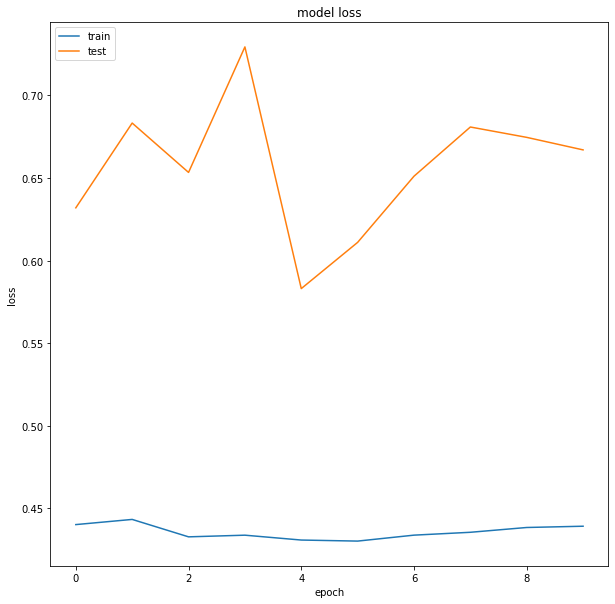

In [8]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()



In [9]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print("Accurracy: {}".format(scores[1]))



3278/3278 [==============================] - 30s 9ms/step - loss: 0.4818 - accuracy: 0.8389
Accurracy: 0.8388931751251221


In [10]:
y_pred = (model.predict(seq_array, verbose=1, batch_size=200) > 0.5).astype("int32")
# y_pred = model.predict_classes(seq_array, verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)

print("Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels")
cm = confusion_matrix(y_true, y_pred)
print(cm)



3278/3278 [==============================] - 25s 7ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[369499  47333]
 [ 58278 180424]]


In [11]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print("precision = ", precision, "\n", "recall = ", recall)


precision =  0.7921776279104484 
 recall =  0.7558545801878492
